<img src="data/scikit_learn.jpg" style="width:800px; height:400px"/>

- http://blog.kaggle.com/2015/04/15/scikit-learn-video-2-setting-up-python-for-machine-learning/

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
train.shape

(10886, 12)

In [5]:
test = pd.read_csv('data/test.csv')
test['datetime'] = pd.to_datetime(test['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## Feature Engineering

In [6]:
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second
train["dayofweek"] = train["datetime"].dt.dayofweek

test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek

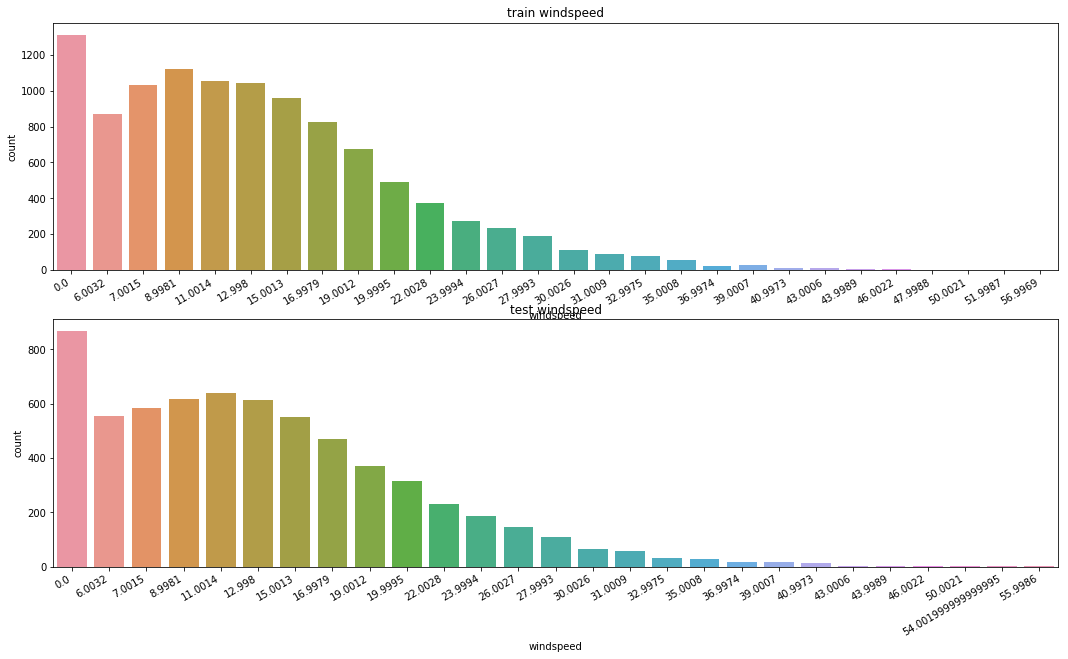

In [7]:
# widspeed column has many 0 values, so we will fit it
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count',title="train windspeed")
sb.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count',title="test windspeed")
sb.countplot(data=test, x="windspeed", ax=axes[1]);

In [8]:
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]

In [9]:
# Then we will use machind learning to replace those 0 windspeed
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    # First, we will divide df into two datasets: wind0 and windNot0
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    # Decide features to predict windspeed
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    # change windspeed datatype to str
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

    # use randomforest classifier
    rfModel_wind = RandomForestClassifier()

    # machine learn windspeed based on each feature
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    # predict 0 windspeed
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])

    # Create new dataframe to compare both predictions
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0

    # assign values to 0 windspeed
    predictWind0["windspeed"] = wind0Values

    # append two predictions
    data = predictWindNot0.append(predictWind0)

    # change datatype
    data["windspeed"] = data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    return data

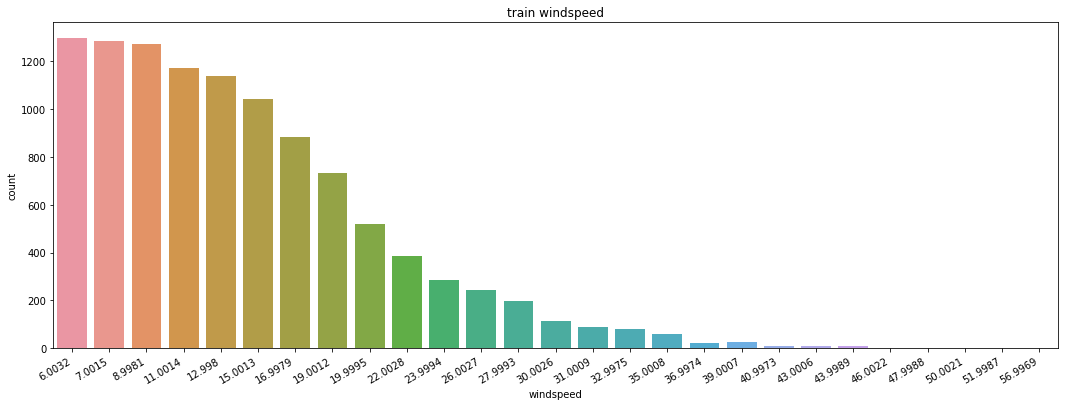

In [10]:
# fix 0 values using function!
train = predict_windspeed(train)
test = predict_windspeed(test)

# visualize our new windspeed without 0 values
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sb.countplot(data=train, x="windspeed", ax=ax1);

In [11]:
# continuous feature = ["temp","humidity","windspeed","atemp"]
# category type change to 'category'
categorical_features = ["season","holiday","workingday","weather","dayofweek","month","year","hour"]

for feature in categorical_features:
    train[feature] = train[feature].astype("category")
    test[feature] = test[feature].astype("category")

In [12]:
features = ["season", "weather", "temp", "atemp", "humidity", "windspeed","year", "hour", "dayofweek", "holiday", "workingday"]

In [13]:
X_train = train[features]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [14]:
X_test = test[features]
X_test.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
2,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1
3,1,1,9.84,11.365,60,15.0013,2011,5,3,0,1
4,1,1,9.02,10.605,60,15.0013,2011,6,3,0,1


In [15]:
y_train = train["count"]
y_train.head()

0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [16]:
#Perform cross validation to split data and help them learn many models
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## RandomForest

Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE). The RMSLE is calculated as:

$$ \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (\log(p_i + 1) - (\log(a_i +1))^2 }$$
  

Where:
- n is the number of hours in the test set
- p_i is your predicted count
- a_i is the actual count
- log(x) is the natural logarithm


- RMSLE **gives more penalty to underfitting** than overfitting. 
- It's more accurate if the **RMSLE value is closer to 0.**

In [17]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # add 1 to both predict, actual and sqrt them
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # find the difference square it
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # calculate the mean and sqrt it
    mean_difference = difference.mean()
    score = np.sqrt(mean_difference)
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [18]:
# import cross validation to evaulate generalization performance 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [19]:
from sklearn.ensemble import RandomForestRegressor
max_depth_list = []
model = RandomForestRegressor(n_estimators=200,n_jobs=-1,random_state=0)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [20]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
# We know score closer to 0 is better
print("Score= {0:.5f}".format(score))

CPU times: user 7.06 s, sys: 4.93 s, total: 12 s
Wall time: 36.2 s
Score= 0.32976


### Train

In [21]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [22]:
# prediction
predictions = model.predict(X_test)
predictions[0:10]

array([ 12.655,   3.365,   3.095,   6.04 ,  38.295, 105.545, 237.95 ,
       137.245,  62.275,  63.435])

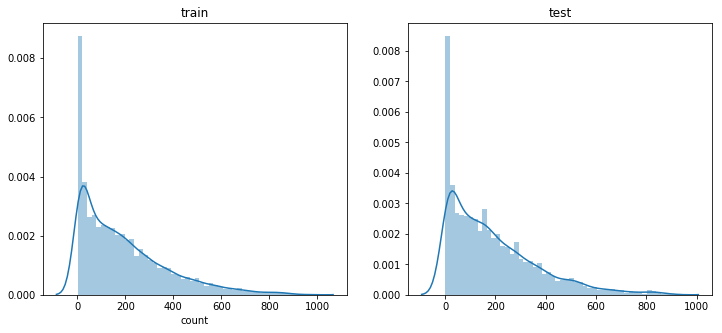

In [23]:
# visualize predicted values
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sb.distplot(y_train,ax=ax1,bins=50)
ax1.set(title="train")
sb.distplot(predictions,ax=ax2,bins=50)
ax2.set(title="test");

## Submission

In [25]:
submission = pd.read_csv("data/sampleSubmission.csv")
submission
submission["count"] = predictions
submission.head()

,datetime,count
0,2011-01-20 00:00:00,12.655
1,2011-01-20 01:00:00,3.365
2,2011-01-20 02:00:00,3.095
3,2011-01-20 03:00:00,6.040
4,2011-01-20 04:00:00,38.295


In [26]:
submission.to_csv("Score_{0:.5f}_submission.csv".format(score), index=False)